In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dateutil import parser
from statsmodels.tsa.stattools import grangercausalitytests

In [2]:
# Define the path to the folder containing the CSV files
folder_path = 'pendle_data'

# Initialize an empty DataFrame for the combined data
pt_df = pd.DataFrame()
yt_df = pd.DataFrame()
imp_apy_df = pd.DataFrame()

def get_maturity(month_year: pd.Series) -> str:
    # Define a mapping from month abbreviations to numbers
    month_map = {
        'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04',
        'may': '05', 'jun': '06', 'jul': '07', 'aug': '08',
        'sep': '09', 'oct': '10', 'nov': '11', 'dec': '12'
    }
    
    # Extract the month and year parts from the input
    month = month_year.str[:3].str.lower().map(month_map)
    year = '20' + month_year.str[-2:]
    
    # Combine month and year into MM-YYYY format
    return month + '-' + year

# Function to format the data based on the token type
def format_data(df: pd.DataFrame, token_type: str) -> pd.DataFrame:
    if token_type in ['pt', 'yt']:
        df['token'] = df['source_file'].str[3:-7]
        df = df.loc[:, ['time', 'volume', 'value', 'maturity', 'token']].copy()
        df.rename(columns={'value': f'{token_type}_price'}, inplace=True)
    elif token_type == 'imp_apy':
        df['token'] = df['source_file'].str[8:-7]
        df = df.loc[:, ['time', 'underlyingApy', 'impliedApy', 'maturity', 'token']].copy()
    return df

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        temp_df = pd.read_csv(file_path)
        temp_df['source_file'] = filename[:-4]
        temp_df['maturity'] = get_maturity(temp_df['source_file'].str[-6:])

        if filename.startswith('pt'):
            temp_df = format_data(temp_df, 'pt')
            pt_df = pd.concat([pt_df, temp_df], ignore_index=True)
        elif filename.startswith('yt'):
            temp_df = format_data(temp_df, 'yt')
            yt_df = pd.concat([yt_df, temp_df], ignore_index=True)
        elif filename.startswith('imp_apy'):
            temp_df = format_data(temp_df, 'imp_apy')
            imp_apy_df = pd.concat([imp_apy_df, temp_df], ignore_index=True)
        else:
            print(f'Unknown file type: {filename}')
            continue

# Merge the pt, yt, and imp_apy DataFrames on time, maturity, and token using an outer join
token_price_df = pd.merge(pt_df, yt_df, on=['time', 'maturity', 'token', 'volume'], how='outer')  # volume is always the same for pt and yt
final_df = pd.merge(token_price_df, imp_apy_df, on=['time', 'maturity', 'token'], how='outer')
final_df['time'] = pd.to_datetime(final_df['time'], format='%a %b %d %Y %H:%M:%S GMT%z (Eastern European Summer Time)')
final_df['time'] = final_df['time'].dt.tz_convert('UTC')

In [3]:
final_df[final_df['time'].dt.to_period('M') == '2024-06']

/home/lauri/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


,time,volume,pt_price,maturity,token,yt_price,underlyingApy,impliedApy
322,2024-06-01 00:00:00+00:00,3.415657e+02,0.863853,08-2024,ena,0.136147,0.0000,0.8225
323,2024-06-01 01:00:00+00:00,3.721824e+04,0.861686,08-2024,ena,0.138314,0.0000,0.8419
324,2024-06-01 02:00:00+00:00,9.064718e+02,0.861792,08-2024,ena,0.138208,0.0000,0.8415
325,2024-06-01 03:00:00+00:00,3.309835e+04,0.863812,08-2024,ena,0.136188,0.0000,0.8244
326,2024-06-01 04:00:00+00:00,4.903767e+04,0.866812,08-2024,ena,0.133188,0.0000,0.7991
...,...,...,...,...,...,...,...,...
6250,2024-06-30 19:00:00+00:00,1.014127e+06,0.986242,07-2024,susde,0.013758,0.0941,0.2323
6251,2024-06-30 20:00:00+00:00,4.037378e+05,0.986281,07-2024,susde,0.013719,0.0941,0.2320
6252,2024-06-30 21:00:00+00:00,0.000000e+00,0.986320,07-2024,susde,0.013680,0.0941,0.2317
6253,2024-06-30 22:00:00+00:00,5.669438e+04,0.986312,07-2024,susde,0.013688,0.0941,0.2323


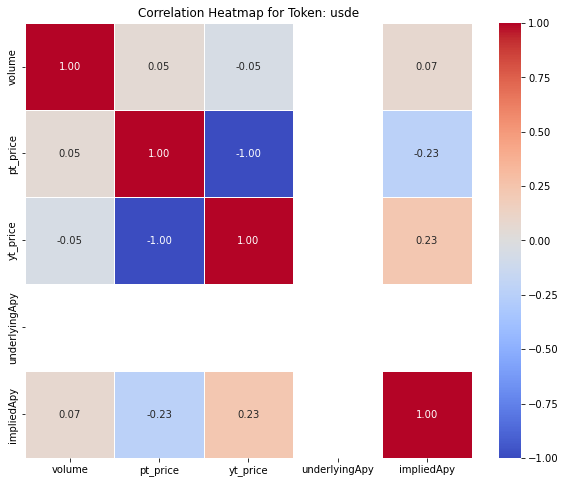

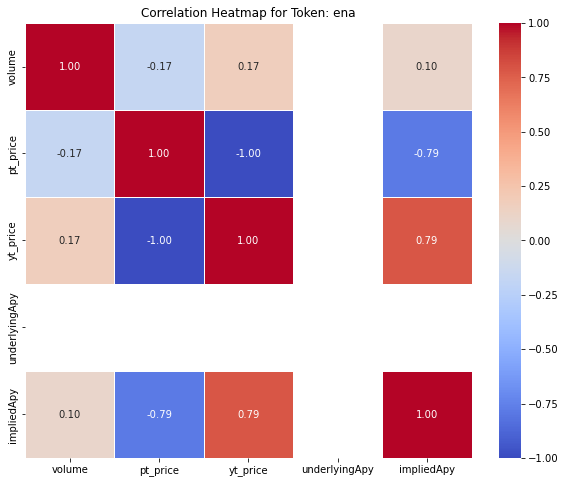

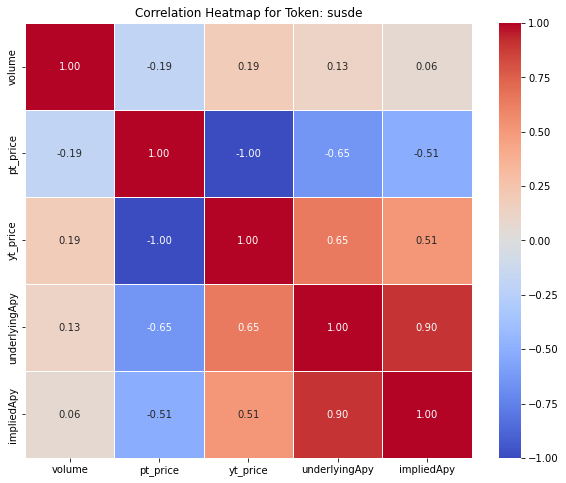

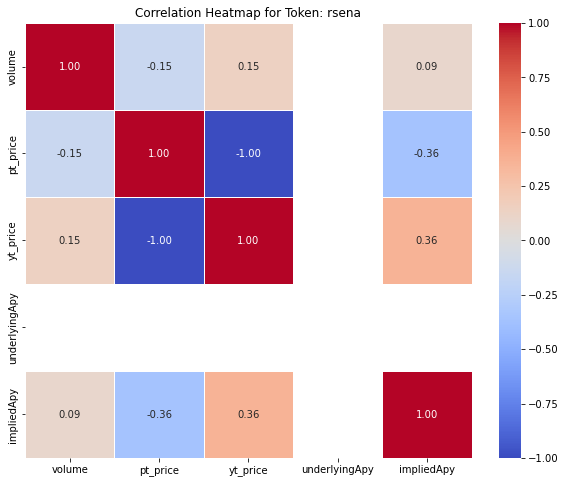

In [4]:
# List of unique tokens
unique_tokens = final_df['token'].unique()

# Function to create correlation matrix and heatmap
def create_correlation_heatmap(df: pd.DataFrame, token: str) -> None:
    corr_matrix = df.corr()
    
    # Plotting the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title(f'Correlation Heatmap for Token: {token}')
    plt.show()

# Loop through each unique token
for token in unique_tokens:
    token_df = final_df[final_df['token'] == token]
    create_correlation_heatmap(token_df, token)


In [5]:
"""
Groupy by token amd maturity, get mean implied apy per day, sum volume
"""

daily_df = final_df.groupby(['token', 'maturity', pd.Grouper(key='time', freq='D')]).agg({
    'volume': 'sum',
    'impliedApy': 'mean',
    'yt_price': 'last',
    'pt_price': 'last',
    'underlyingApy': 'mean'
}).reset_index()
daily_df.to_csv('data/pendle_token_data.csv', index=False)
daily_df

,token,maturity,time,volume,impliedApy,yt_price,pt_price,underlyingApy
0,ena,08-2024,2024-05-25 00:00:00+00:00,9.393385e+05,0.868220,0.143608,0.856392,0.0
1,ena,08-2024,2024-05-26 00:00:00+00:00,8.747086e+05,0.822721,0.146067,0.853933,0.0
2,ena,08-2024,2024-05-27 00:00:00+00:00,2.828536e+06,0.896312,0.150725,0.849275,0.0
3,ena,08-2024,2024-05-28 00:00:00+00:00,1.943333e+06,0.887133,0.143475,0.856525,0.0
4,ena,08-2024,2024-05-29 00:00:00+00:00,2.424128e+06,0.878417,0.146298,0.853702,0.0
...,...,...,...,...,...,...,...,...
295,usde,12-2024,2024-07-20 00:00:00+00:00,1.571316e+05,0.079371,0.036320,0.963680,0.0
296,usde,12-2024,2024-07-21 00:00:00+00:00,6.313509e+04,0.097863,0.039727,0.960273,0.0
297,usde,12-2024,2024-07-22 00:00:00+00:00,3.075975e+04,0.100612,0.039853,0.960147,0.0
298,usde,12-2024,2024-07-23 00:00:00+00:00,1.005253e+05,0.105787,0.041488,0.958512,0.0


<AxesSubplot:>

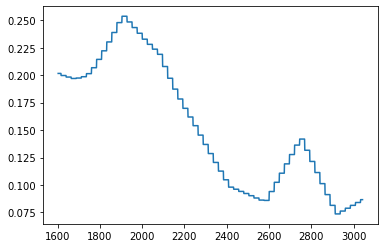

In [6]:
final_df[(final_df['token'] == 'susde') & (final_df['maturity'] == '09-2024')]['underlyingApy'].plot()


### Long Yield Strategy
Previously it was noticed that eth returns granger cause impliedApy on ena. Here we further investigate wether this relationship can be used to predict impliedApy on pendle ena tokens, and thus utilized in a long yield strategy.

Tests will be conducted both on a hourly and daily frequency

In [7]:
import networkx as nx
from typing import Dict, List


def run_granger_causality_tests(df: pd.DataFrame, tokens: list, y_values: list, x_values: list) -> dict:
    # Dictionary to store results
    causality_results = {}

    # Loop through each token
    for token in tokens:
        token_data = df[df['token'] == token].dropna()
        causality_results[token] = {}

        # Loop through each y_value
        for y in y_values:
            causality_results[token][y] = {}

            # Check each x variable for Granger causality on y
            for x in x_values:
                if x != y:  # Avoid testing a variable on itself
                    test_data = token_data[[y, x]].dropna()  # Ensure data has no NAs

                    # Check for constant values
                    if test_data[x].nunique() <= 1 or test_data[y].nunique() <= 1:
                        print(f"Skipping {x} -> {y} due to constant values in data for token {token}.")
                        continue

                    try:
                        result = grangercausalitytests(test_data, maxlag=10, verbose=False)  # Run Granger Test
                        p_values = [result[lag][0]['ssr_ftest'][1] for lag in range(1, 11)]
                        causality_results[token][y][x] = p_values
                    except Exception as e:
                        print(f"Error in testing {x} -> {y} for token {token}: {str(e)}")

    return causality_results

def plot_granger_causality_network(results: Dict[str, Dict[str, Dict[str, List[float]]]],
                                   significance_level: float = 0.05,
                                   layout_type: str = 'shell') -> None:
    """
    Visualizes a network of Granger causality relationships based on p-values.

    Parameters:
        results (dict): A nested dictionary containing tokens, variables, and p-values for various lags.
                        Structure: {token: {dependent_var: {independent_var: [p-values]}}}
        significance_level (float): The threshold below which a p-value is considered significant.
        layout_type (str): Type of network layout ('shell', 'spring', 'circular').

    Returns:
        None: This function plots a network graph.
    """
    # Create a directed graph
    G = nx.DiGraph()

    # Loop over the data to add nodes and edges
    for token, token_data in results.items():
        for y_var, causations in token_data.items():
            for x_var, p_values in causations.items():
                for lag, p_value in enumerate(p_values, start=1):
                    if p_value < significance_level:  # Check for significant causality
                        source = f"{x_var} (Lag {lag})"
                        target = f"{y_var} ({token})"
                        G.add_edge(source, target, weight=p_value, label=f"{p_value:.4f}")

    # Choose the layout based on the layout_type parameter
    if layout_type == 'shell':
        pos = nx.shell_layout(G)
    elif layout_type == 'spring':
        pos = nx.spring_layout(G)
    elif layout_type == 'circular':
        pos = nx.circular_layout(G)
    else:
        raise ValueError("Unsupported layout type. Choose 'shell', 'spring', or 'circular'.")

    # Draw the graph
    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=5000, alpha=0.6)
    edges = nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='gray', node_size=5000)
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='green')

    plt.title('Network of Granger Causality by Token and Variable')
    plt.axis('off') 
    plt.show()

In [8]:
from datetime import datetime
from utils import fetch_futures_funding_rates, process_funding_data

# Define parameters
symbol = 'ETHUSDT'  # ETH/USDT perpetual contract
start_date = '2024-04-01'  # Start date (format YYYY-MM-DD)
end_date = datetime.now().strftime('%Y-%m-%d')  # Today's date

# Fetch and process the data
funding_data = fetch_futures_funding_rates(symbol, start_date, end_date)
daily_funding = process_funding_data(funding_data)
daily_funding

,Datetime,Daily Funding Rate,Funding 7-Day MA
0,2024-04-01 00:00:00+00:00,0.116069,NaN
1,2024-04-02 00:00:00+00:00,0.037676,NaN
2,2024-04-03 00:00:00+00:00,0.030000,NaN
3,2024-04-04 00:00:00+00:00,0.030000,NaN
4,2024-04-05 00:00:00+00:00,0.030000,NaN
...,...,...,...
110,2024-07-20 00:00:00+00:00,0.016312,0.019369
111,2024-07-21 00:00:00+00:00,0.018245,0.019184
112,2024-07-22 00:00:00+00:00,0.020436,0.019476
113,2024-07-23 00:00:00+00:00,0.026805,0.020615


In [9]:
final_df[final_df['token'] == 'ena']


,time,volume,pt_price,maturity,token,yt_price,underlyingApy,impliedApy
163,2024-05-25 09:00:00+00:00,124194.408918,0.840575,08-2024,ena,0.159425,0.0,0.9404
164,2024-05-25 10:00:00+00:00,39087.925233,0.843394,08-2024,ena,0.156606,0.0,0.9163
165,2024-05-25 11:00:00+00:00,37034.329809,0.841555,08-2024,ena,0.158445,0.0,0.9329
166,2024-05-25 12:00:00+00:00,48863.604672,0.845139,08-2024,ena,0.154861,0.0,0.9023
167,2024-05-25 13:00:00+00:00,5298.960595,0.844842,08-2024,ena,0.155158,0.0,0.9054
...,...,...,...,...,...,...,...,...
1598,2024-07-24 04:00:00+00:00,0.000000,0.953437,08-2024,ena,0.046563,0.0,0.6253
1599,2024-07-24 05:00:00+00:00,5274.411551,0.953162,08-2024,ena,0.046838,0.0,0.6310
1600,2024-07-24 06:00:00+00:00,6164.731871,0.953514,08-2024,ena,0.046486,0.0,0.6258
1601,2024-07-24 07:00:00+00:00,15282.582619,0.952608,08-2024,ena,0.047392,0.0,0.6426


In [10]:
external_data = pd.read_csv('data/ena_1h_data.csv')
external_data['time'] = pd.to_datetime(external_data['Datetime'])

combined_df = pd.merge(final_df, external_data.drop(columns='Datetime'), on='time').sort_values('time')

causality_hypothesis_variables = ['ETH_Returns', 'ENA_Returns', 'underlyingApy']
y_values = ['impliedApy', 'underlyingApy']
tokens = combined_df['token'].unique()

hourly_results = run_granger_causality_tests(combined_df, tokens, y_values, causality_hypothesis_variables)

Skipping underlyingApy -> impliedApy due to constant values in data for token ena.
Skipping ETH_Returns -> underlyingApy due to constant values in data for token ena.
Skipping ENA_Returns -> underlyingApy due to constant values in data for token ena.
Skipping underlyingApy -> impliedApy due to constant values in data for token usde.
Skipping ETH_Returns -> underlyingApy due to constant values in data for token usde.
Skipping ENA_Returns -> underlyingApy due to constant values in data for token usde.
Skipping underlyingApy -> impliedApy due to constant values in data for token rsena.
Skipping ETH_Returns -> underlyingApy due to constant values in data for token rsena.
Skipping ENA_Returns -> underlyingApy due to constant values in data for token rsena.


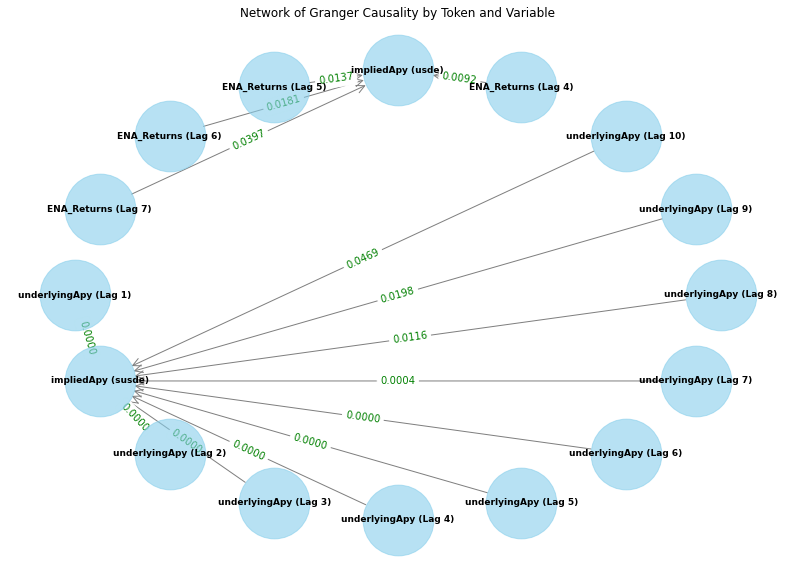

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

plot_granger_causality_network(hourly_results, 0.05, 'shell')

# Daily level granger causality
- Needs some fixing; there should not be any underlyingAoy available on a daily level for other tokens than susde

In [12]:
daily_external_data = pd.read_csv('data/ena_1d_data.csv')
daily_external_data['time'] = pd.to_datetime(daily_external_data['Datetime'])

daily_combined_df = pd.merge(daily_df, daily_external_data.drop(columns='Datetime'), on='time').sort_values('time')

# stationarize impliedApy and underlyingApy
daily_combined_df['impliedApy'] = daily_combined_df['impliedApy'].diff()
daily_combined_df['underlyingApy'] = daily_combined_df['underlyingApy'].diff()

# Define the variables for analysis
causality_hypothesis_variables = ['ETH_Returns', 'ENA_Returns', 'underlyingApy']
y_values = ['impliedApy', 'underlyingApy']
tokens = daily_combined_df['token'].unique()

causality_results = run_granger_causality_tests(daily_combined_df, tokens, y_values, causality_hypothesis_variables)

Error in testing ETH_Returns -> impliedApy for token rsena: Insufficient observations. Maximum allowable lag is 1
Error in testing ENA_Returns -> impliedApy for token rsena: Insufficient observations. Maximum allowable lag is 1
Error in testing underlyingApy -> impliedApy for token rsena: Insufficient observations. Maximum allowable lag is 1
Error in testing ETH_Returns -> underlyingApy for token rsena: Insufficient observations. Maximum allowable lag is 1
Error in testing ENA_Returns -> underlyingApy for token rsena: Insufficient observations. Maximum allowable lag is 1


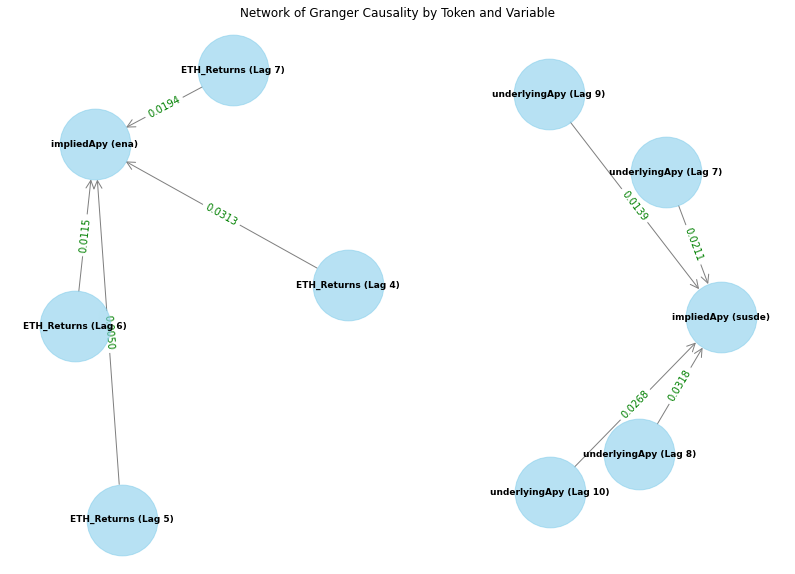

In [24]:
plot_granger_causality_network(causality_results, 0.05, 'spring')

### Observations

Observations:

1) Hourly data:
- ENA returns granger cause impliedApy on some tokens
- ETH returns has weaker granger causality on impliedApy, but displays significant granger causality on underlyingApy
- underlyingApy, as one could expect, has a strong granger causality on impliedApy on susde

The relationship of ETH and ENA returns granger causing underlyingApy, and underlyingApy granger causing impliedApy on susde, could perhaps be used to predict impliedApy on susde. This could be used in a long yield strategy, where one would long susde when the model predicts a high impliedApy, and short when the model predicts a low impliedApy.

2) Daily data:
- ETH returns granger cause impliedApy on susde on several lags on hourly frequency - this is not the case on the daily frequency.
- The implied APY of ENA is granger caused by several lags of ETH returns even on the daily frequency.

